In [1]:
import os
import pandas as pd
import configparser
import matplotlib.pyplot as plt

os.environ['TEJAPI_KEY'] = 'your key' 
os.environ['TEJAPI_BASE'] = 'your base'

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from zipline.data import bundles
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.data import TWEquityPricing
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [3]:
from logbook import Logger, FileHandler, INFO

log_handler = FileHandler('log.txt',
                            format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)

log_handler.push_application()
log = Logger('Algorithm')

In [4]:
start = '2018-01-01'
end = '2023-12-31'
stock_list = ['0056', '00713', '00878', '00919', '00929', 'IR0001']
calendar_name = 'TEJ'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(stock_list)

!zipline ingest -b tquant

[2024-05-28 07:00:43.864753] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   
Currently used TEJ API key call quota 740/100000 (0.74%)
Currently used TEJ API key data quota 8807717/10000000 (88.08%)
[2024-05-28 07:00:46.621764] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [5]:
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():

    return Pipeline(
        columns = {
            "curr_price": TWEquityPricing.close.latest,
    },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(), pd.Timestamp(start, tz='UTC'), pd.Timestamp(end, tz='UTC'))
my_pipeline

curr_price
2018-01-03 00:00:00+00:00 Equity(0 [0056])        25.13
                          Equity(1 [00713])       30.45
2018-01-04 00:00:00+00:00 Equity(0 [0056])        25.31
                          Equity(1 [00713])       30.60
2018-01-05 00:00:00+00:00 Equity(0 [0056])        25.41
...                                                 ...
2023-12-29 00:00:00+00:00 Equity(0 [0056])        37.33
                          Equity(1 [00713])       50.30
                          Equity(2 [00878])       21.77
                          Equity(3 [00919])       22.21
                          Equity(4 [00929])       19.15

[4197 rows x 1 columns]

In [6]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrats')

In [7]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    
    for asset in out_dir.index:
        stock_position = context.portfolio.positions[asset].amount
        if stock_position == 0:
            order_percent(asset, 0.25)

In [8]:
results = run_algorithm(
    start = pd.Timestamp(start, tz='UTC'),
    end = pd.Timestamp(end, tz ='UTC'),
    initialize=initialize,
    handle_data=handle_data,
    bundle='tquant',
    data_frequency='daily',
    capital_base=1e6,
    trading_calendar=get_calendar(calendar_name))

results

,period_open,period_close,net_leverage,ending_cash,short_exposure,ending_exposure,starting_cash,returns,treasury_return,portfolio_value,...,algorithm_period_return,treasury_period_return,period_label,max_leverage,algo_volatility,benchmark_period_return,excess_return,benchmark_volatility,sharpe,max_drawdown
2018-01-02 13:30:00+08:00,2018-01-02 09:01:00+08:00,2018-01-02 13:30:00+08:00,0.000000,1000000.000000,0.0,0.00,1000000.000000,0.000000,0.0,1.000000e+06,...,0.000000,0.0,2018-01,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000
2018-01-03 13:30:00+08:00,2018-01-03 09:01:00+08:00,2018-01-03 13:30:00+08:00,0.000000,1000000.000000,0.0,0.00,1000000.000000,0.000000,0.0,1.000000e+06,...,0.000000,0.0,2018-01,0.000000,0.000000,0.008481,-0.008481,NaN,NaN,0.000000
2018-01-04 13:30:00+08:00,2018-01-04 09:01:00+08:00,2018-01-04 13:30:00+08:00,0.501309,498329.335867,0.0,500945.97,1000000.000000,-0.000725,0.0,9.992753e+05,...,-0.000725,0.0,2018-01,0.501309,0.006642,0.012875,-0.013600,0.046297,-9.165151,-0.000725
2018-01-05 13:30:00+08:00,2018-01-05 09:01:00+08:00,2018-01-05 13:30:00+08:00,0.501620,498329.335867,0.0,501569.04,498329.335867,0.000624,0.0,9.998984e+05,...,-0.000102,0.0,2018-01,0.501620,0.008750,0.015785,-0.015887,0.046130,-0.728463,-0.000725
2018-01-08 13:30:00+08:00,2018-01-08 09:01:00+08:00,2018-01-08 13:30:00+08:00,0.502989,498329.335867,0.0,504323.47,498329.335867,0.002755,0.0,1.002653e+06,...,0.002653,0.0,2018-01,0.502989,0.021141,0.019142,-0.016489,0.040668,6.326096,-0.000725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,1.083660,-160021.674045,0.0,2072791.71,-160021.674045,0.002165,0.0,1.912770e+06,...,0.912770,0.0,2023-12,1.155679,0.091116,1.067382,-0.154611,0.166363,1.275269,-0.163822
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,1.082884,-160021.674045,0.0,2090690.82,-160021.674045,0.009358,0.0,1.930669e+06,...,0.930669,0.0,2023-12,1.155679,0.091160,1.084639,-0.153970,0.166337,1.291503,-0.163822
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,1.082201,-160021.674045,0.0,2106725.44,-160021.674045,0.008305,0.0,1.946704e+06,...,0.946704,0.0,2023-12,1.155679,0.091187,1.101054,-0.154350,0.166308,1.305948,-0.163822
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,1.082456,-160021.674045,0.0,2100712.63,-160021.674045,-0.003089,0.0,1.940691e+06,...,0.940691,0.0,2023-12,1.155679,0.091167,1.103269,-0.162578,0.166251,1.299490,-0.163822


In [31]:
import re
from datetime import datetime
from collections import defaultdict

equity_stats = defaultdict(lambda: {'count': 0, 'total_div_owed': 0.0, 'min_date': None, 'max_date': None})
dates = {}
div_owed_total = 0

with open("log.txt") as f:
    file = f.read()
    log = file.split("\n")
    pattern = re.compile(r"Equity\((\d+) \[(\d+)\]\), cash_dividend amount: ([\d.]+), pay_date: (\d{4}-\d{2}-\d{2}), div_owed: ([\d.]+)")
    for line in log:
        match = pattern.search(line)
        if match:
            equity_id = match.group(1)
            equity_code = match.group(2)
            cash_dividend_amount = float(match.group(3))
            pay_date = match.group(4)
            div_owed = float(match.group(5))
            div_owed_total += div_owed

            key = f"{equity_id} [{equity_code}]"
            equity_stats[key]['count'] += 1
            equity_stats[key]['total_div_owed'] += div_owed

            pay_date_dt = datetime.strptime(pay_date, '%Y-%m-%d')
            if equity_stats[key]['min_date'] is None or pay_date_dt < equity_stats[key]['min_date']:
                equity_stats[key]['min_date'] = pay_date_dt
            if equity_stats[key]['max_date'] is None or pay_date_dt > equity_stats[key]['max_date']:
                equity_stats[key]['max_date'] = pay_date_dt


        date_pattern_open = re.compile(r"(first open): ([\d-]+ [\d:]+[+\d:]+)")
        date_pattern_close = re.compile(r"(last close): ([\d-]+ [\d:]+[+\d:]+)")
        dates_open = {match[0]: match[1] for match in date_pattern_open.findall(line)}
        dates_close = {match[0]: match[1] for match in date_pattern_close.findall(line)}
        if len(dates_open) != 0:
            dates.update(dates_open)
        if len(dates_close) != 0:
            dates.update(dates_close)

print("高股息 ETF")
for key, stats in equity_stats.items():
    if stats['min_date'] and stats['max_date']:
        duration = (stats['max_date'] - stats['min_date']).days
    else:
        duration = 0
    print(f"Equity {key}: 發放股利次數: {stats['count']}, Total div_owed: {stats['total_div_owed']:.2f}, 持續時間: {duration} 天")

first_open = datetime.fromisoformat(dates["first open"])
last_close = datetime.fromisoformat(dates["last close"])
total_days = (last_close - first_open).days

print(f"回測期間共 {total_days} 天，獲得股利共 {round(div_owed_total)} 元，平均每天可獲得股息 {round(div_owed_total/total_days)} 元")

高股息 ETF
Equity 0 [0056]: 發放股利次數: 7, Total div_owed: 108153.15, 持續時間: 1813 天
Equity 1 [00713]: 發放股利次數: 10, Total div_owed: 113875.86, 持續時間: 1844 天
Equity 2 [00878]: 發放股利次數: 13, Total div_owed: 61303.05, 持續時間: 1089 天
Equity 3 [00919]: 發放股利次數: 3, Total div_owed: 32541.32, 持續時間: 182 天
Equity 4 [00929]: 發放股利次數: 6, Total div_owed: 16917.78, 持續時間: 154 天
回測期間共 2187 天，獲得股利共 332791 元，平均每天可獲得股息 152 元


Start date,2018-01-02
End date,2023-12-29
Total months,69
,Backtest
Annual return,13.677%
Cumulative returns,110.48%
Annual volatility,11.18%
Sharpe ratio,1.20
Calmar ratio,0.70
Stability,0.87
Max drawdown,-19.478%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.48,2022-04-06,2022-10-21,2023-04-12,248
1,19.19,2020-01-20,2020-03-19,2020-12-01,211
2,9.45,2018-08-31,2018-10-26,2019-04-17,150
3,8.94,2021-05-10,2021-05-17,2021-11-15,132
4,7.12,2023-09-15,2023-10-31,2023-11-20,44


Stress Events,mean,min,max
New Normal,0.05%,-5.35%,3.86%


Top 10 long positions of all time,max
sid,
00701,27.06%
00919,26.45%
0056,26.34%
00929,25.98%
00713,25.71%
00878,25.09%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
00701,27.06%
00919,26.45%
0056,26.34%
00929,25.98%
00713,25.71%
00878,25.09%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

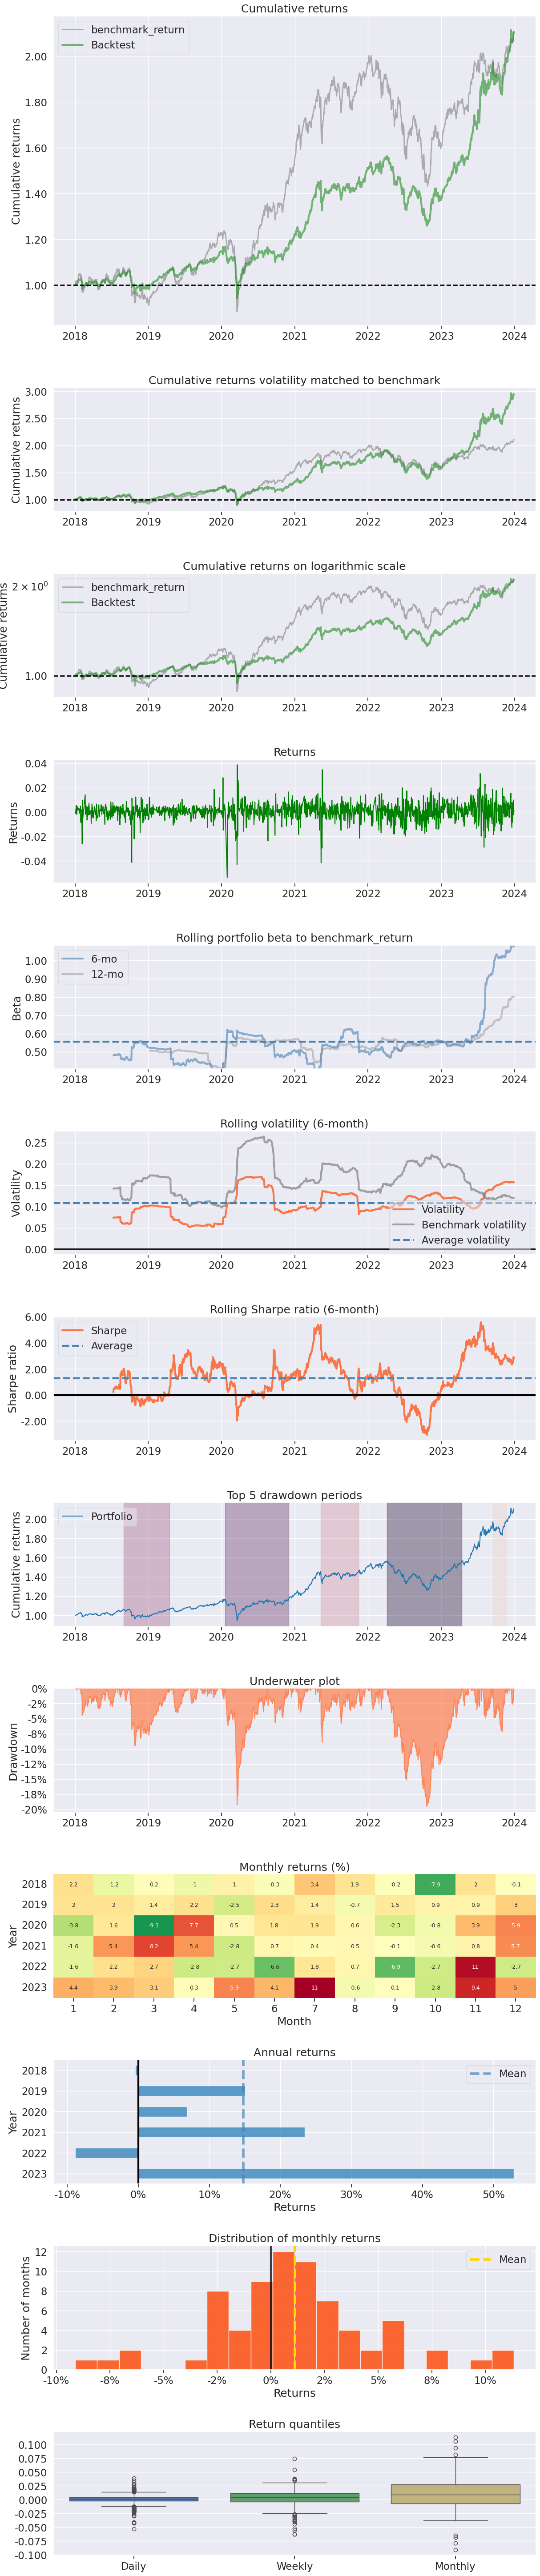

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

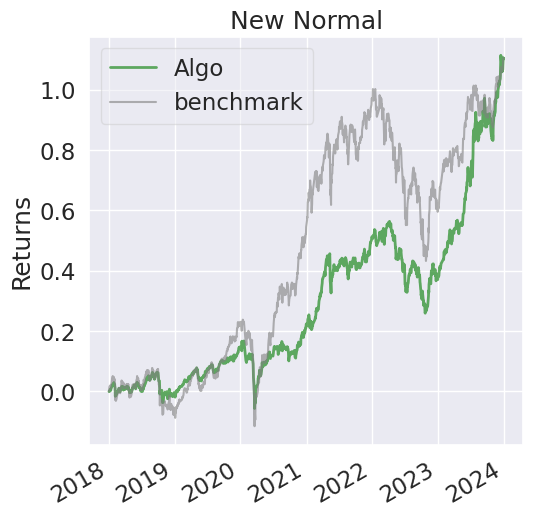

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

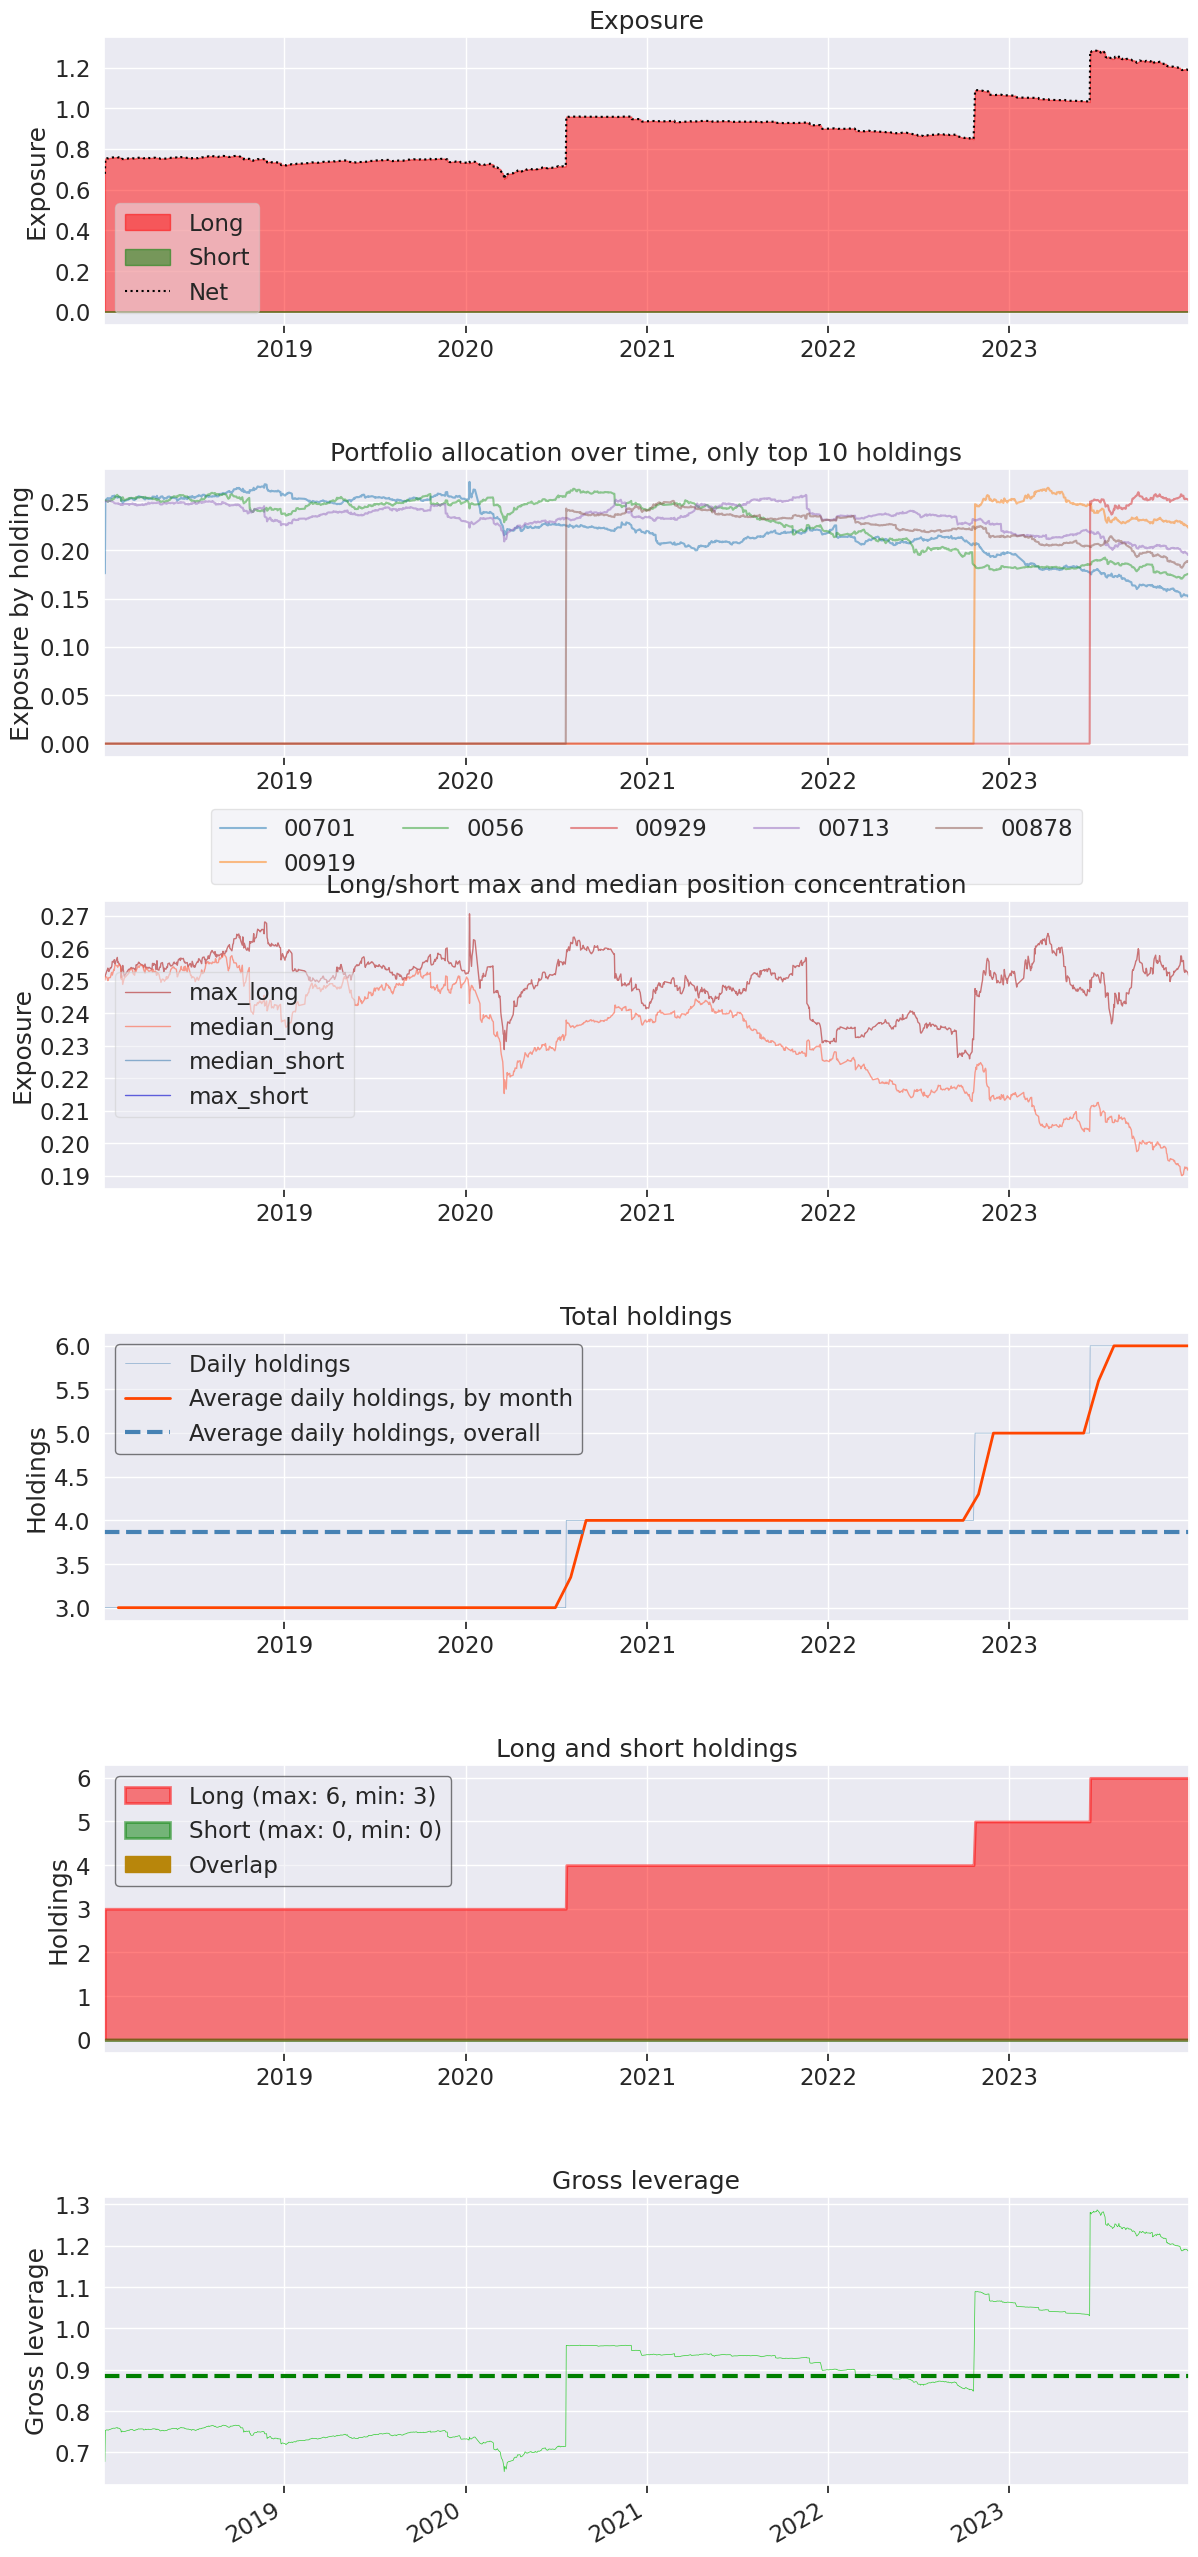

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

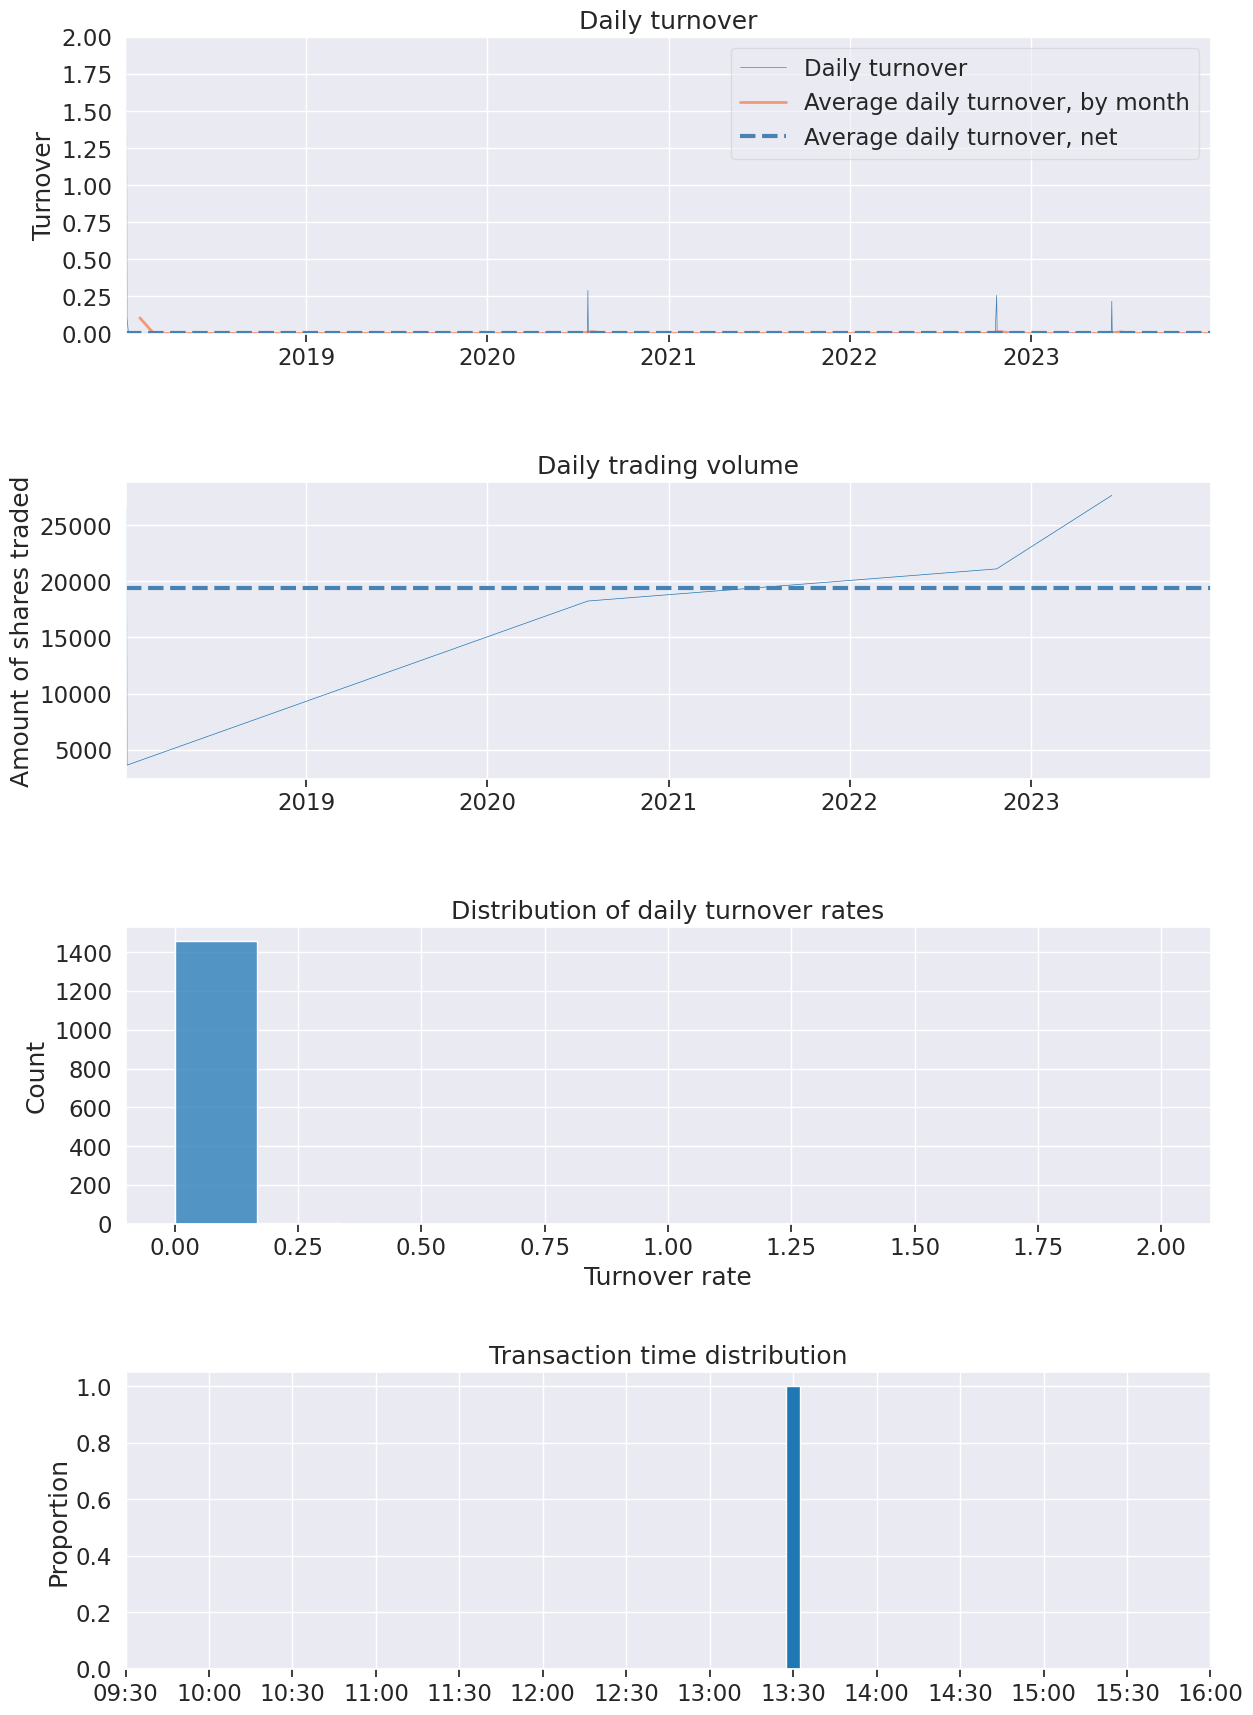

In [23]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                            benchmark_rets = benchmark_rets,
                            round_trips=False)